In [ ]:
# pull training data and link it to analysis-ready data
# todo: either access locally or use Window to access on S3 (might need to use bbox instead though)

In [1]:
import os

try:
    from common.sagemaker_env import LABELBOX_API_KEY
except: 
    LABELBOX_API_KEY = os.environ['LABELBOX_API_KEY']

In [3]:
from datetime import datetime, timedelta
from labelbox import Client


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project("clcrkcvn9281j07xybmww69pn")

now = datetime.today()

then = now - timedelta(days=60)

data_rows = project.export_labels(download=True, start=then.strftime('%Y-%m-%d'), end=now.strftime('%Y-%m-%d'))
print(f'{len(data_rows)} data rows')

1 data rows


208 labeled boxes
bare_light


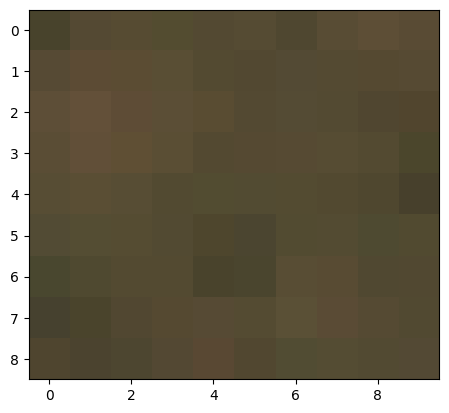

In [45]:
%reload_ext autoreload
%autoreload 2

import h5py
import json
import matplotlib.pyplot as plt
import os

import common.utilities.download as download
import common.utilities.visualization as visualization


labelbox_dir = "./data/testingLabelbox"
if not os.path.exists(labelbox_dir):
    os.makedirs(labelbox_dir)

    
h5_path = f"{labelbox_dir}/labeled_{then.strftime('%Y%m%d')}_{now.strftime('%Y%m%d')}.hdf5"
if os.path.exists(h5_path):
    os.remove(h5_path)
    
fp = h5py.File(h5_path, "w")
parent_group = fp.create_group('s2_labeled')

for row in data_rows:
    row_id = row['ID']
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    all_cog_url = rgb_cog_url.replace('rgb_byte_cog', 'all_uint16_cog')

    print(f'{len(labels)} labeled boxes')
    
    for i, label in enumerate(labels):
        class_title = label['title']
        class_value = label['value']
        label_id = label['featureId']
        geometry = label['geometry']
        
        coordinates = geometry['coordinates'][0][:-1]

        try:
            label_group = parent_group[class_value]
        except KeyError:
            label_group = parent_group.create_group(class_value)

        longitudes = [coord[0] for coord in coordinates]
        latitudes = [coord[1] for coord in coordinates]

        x_min, y_min = min(longitudes), min(latitudes)
        x_max, y_max = max(longitudes), max(latitudes)

        bbox = [x_min, y_min, x_max, y_max]      

        data = download.download_bbox(bbox, all_cog_url, read_all=True)
        # print(f'{class_value}: {data.shape}')

        dataset = label_group.create_dataset(label_id, data=data)

        if i == 120:
            print(class_value)
            visualization.plot_bands(data, bands=[2, 1, 0])

fp.close()
    

In [8]:
print('hey')

hey


## Testing new format to support semantic segmentation

In [71]:
CLASSES = {
    'unclassified': 0,
    'agriculture': 1,
    'bare_dark': 2,
    'bare_light': 3,
    'built': 4,
    'burn': 5,
    'cloud': 6,
    'flooded_vegetation': 7,
    'grass_dry': 8,
    'grass_verdant': 9,
    'shrubs': 10,
    'trees': 11,
    'water': 12,   
}

In [15]:
from datetime import datetime, timedelta
from labelbox import Client


client = Client(api_key=LABELBOX_API_KEY)
project = client.get_project("clcrkcvn9281j07xybmww69pn")

now = datetime.today()
then = now - timedelta(days=60)

data_rows = project.export_labels(download=True, start=then.strftime('%Y-%m-%d'), end=now.strftime('%Y-%m-%d'))
print(f'{len(data_rows)} data rows')

2 data rows


In [132]:
%reload_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal
from patchify import patchify
from shapely.geometry import box
import rasterio

import common.utilities.download as download
import common.utilities.imagery as imagery
import common.utilities.visualization as visualization


RES_M = 10 # meters
INPUT_SIZE = 512

labelbox_dir = "./data/testingLabelbox"
images_dir = f'{labelbox_dir}/images'
labels_dir = f'{labelbox_dir}/labels'
temp_dir = f'{labelbox_dir}/temp'

os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)

    
for row in data_rows:
        
    row_id = row['DataRow ID']
    labels = row['Label']['objects']
    metadata = json.loads(row['Labeled Data'])
    rgb_cog_url = metadata['tileLayerUrl']
    all_cog_url = rgb_cog_url.replace('rgb_byte_cog', 'all_uint16_cog')
    job_name = all_cog_url.split('/')[4]
    
    print(rgb_cog_url)
    
    drow = client.get_data_row(row_id)
    bounds = drow.media_attributes['bounds']
    bbox = bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]
    bbox_poly_ll = box(*bbox)
    print('job bounds:', bbox)
   
    res = RES_M / (111.32 * 1000)
    ncols = int(np.rint(np.abs((bounds[1][0] - bounds[0][0])) / res))
    nrows = int(np.rint(np.abs((bounds[1][1] - bounds[0][1]) / res)))
    labels_data = np.zeros((nrows, ncols)).astype(np.uint8)
    
    print('labels.shape:', labels_data.shape)
    print(f'{len(labels)} labeled boxes')
    
    for i, label in enumerate(labels):
        class_title = label['title']
        class_value = label['value']
        label_id = label['featureId']
        coords = label['geometry']['coordinates'][0][:-1]
        class_idx = CLASSES[class_value]
        
        lons = [coord[0] for coord in coords]
        lats = [coord[1] for coord in coords]

        x_min, y_min = min(lons), min(lats)
        x_max, y_max = max(lons), max(lats)
        bbox = [x_min, y_min, x_max, y_max]   
                
        row_min, col_min = labels_src.index(x_min, y_max)
        row_max, col_max = labels_src.index(x_max, y_min)
                
        labels_data[row_min:row_max, col_min:col_max] = class_idx
                          
        
    image_src = rasterio.open(f'./data/{job_name}/all_uint16.tif')
    image_data = image_src.read(masked=True)
    image_data = image_data.transpose((1, 2, 0))
         
    image_patches = patchify(image_data, (INPUT_SIZE, INPUT_SIZE, image_data.shape[2]), step=INPUT_SIZE)
    label_patches = patchify(labels_data, (INPUT_SIZE, INPUT_SIZE), step=INPUT_SIZE)
    
    assert image_patches.shape[0] == label_patches.shape[0]
    assert image_patches.shape[1] == label_patches.shape[1]
    
    for irow in range(label_patches.shape[0]):
        for icol in range(label_patches.shape[1]):
            label_data = label_patches[irow, icol, :, :]
            nonzero_count = np.count_nonzero(label_data)
            
            if nonzero_count > 100:
                image_data = image_patches[irow, icol, 0, :, :, :]
                image_path = f'{images_dir}/{job_name}_{irow}_{icol}.tif'
                label_path = f'{labels_dir}/{job_name}_{irow}_{icol}.tif'
                
                x_min, y_min, rasterio.transform.xy(image_src.transform, INPUT_SIZE*(irow+1), INPUT_SIZE*icol)
                x_max, y_max, rasterio.transform.xy(image_src.transform, INPUT_SIZE*irow, INPUT_SIZE*(icol+1))             
                bbox = [x_min, y_min, x_max, y_max]   

                imagery.write_array_to_tif(image_data, image_path, bbox, dtype=np.uint16)
                imagery.write_array_to_tif(label_data, label_path, bbox, dtype=np.uint8)
                
                raise
                    

https://data.smartcarte.earth/training/20210101_20210301_south/20210101_20210301_south_rgb_byte_cog.tif
job bounds: (29.296298, -1.5822666762486526, 29.769258833632772, -1.19752)
labels.shape: (4283, 5265)
223 labeled boxes
(512, 512, 4)
{'driver': 'GTiff', 'height': 512, 'width': 512, 'count': 4, 'dtype': <class 'numpy.uint16'>, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.321225825208331e-06, 0.0, 29.41984315124479,
       0.0, -7.078426298475458e-06, -1.2825681441570362)}
(512, 512)
{'driver': 'GTiff', 'height': 512, 'width': 512, 'count': 1, 'dtype': <class 'numpy.uint8'>, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.321225825208331e-06, 0.0, 29.41984315124479,
       0.0, -7.078426298475458e-06, -1.2825681441570362)}


RuntimeError: No active exception to reraise

In [125]:
%%bash

gdalinfo ./data/testingLabelbox/images/20210101_20210301_south_0_0.tif

Driver: GTiff/GeoTIFF
Files: ./data/testingLabelbox/images/20210101_20210301_south_0_0.tif
Size is 512, 512
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (29.419843151244791,-1.282568144157036)
Pixel Size = (0.000005321225825,-0.000007078426298)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=PIXEL
Corner Coordinates:
Upper Left  (  29.4198432,  -1.2825681) ( 29d25'11.44"E,  1d16'57.25"S)
Lower Left  (  29.4198432,  -1.2861923) ( 29d25'11.44"E,  1d

meow (512, 512, 3)
meow (512, 512)


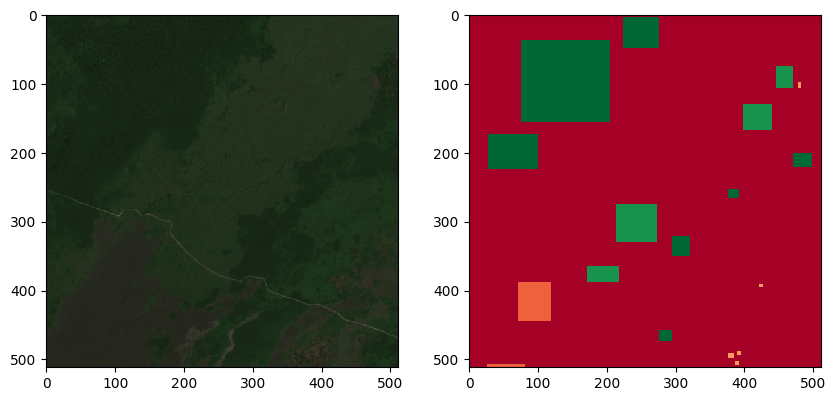

In [137]:
%reload_ext autoreload
%autoreload 2

import common.utilities.visualization as visualization


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))


with rasterio.open("./data/testingLabelbox/images/20210101_20210301_south_0_0.tif") as f:
    data = f.read()
    visualization.plot_bands(data, bands=[2, 1, 0], ax=ax1, scale=True, transpose=True)
    
with rasterio.open("./data/testingLabelbox/labels/20210101_20210301_south_0_0.tif") as f:
    data = f.read(1)
    visualization.plot_bands(data, bands=1, ax=ax2)

In [86]:
%%bash

#gdalinfo ./data/testingLabelbox/temp/20200701_20200901_south_labels.tif
#gdalinfo ./data/testingLabelbox/temp/test_image.tif